# Hidden Markov Models

In [10]:
import numpy as np
import daft
from matplotlib import rc
from IPython.display import Latex
%matplotlib inline

(TeX macro definitions)
$ %TeX macros
\newcommand{\vct}[1]{\boldsymbol{#1}}
\newcommand{\mtx}[1]{\mathbf{#1}}
\newcommand{\rvar}[1]{\mathsf{#1}}
\newcommand{\rvct}[1]{\vct{\rvar{#1}}}
\newcommand{\set}[1]{\mathcal{#1}}
\newcommand{\prob}[1]{\mathbb{P}\left[#1\right]}
\newcommand{\fset}[1]{\left\lbrace #1 \right\rbrace}
\newcommand{\lsb}{\left[}
\newcommand{\rsb}{\right]}
\newcommand{\lpa}{\left(}
\newcommand{\rpa}{\right)}
\newcommand{\lbr}{\left\lbrace}
\newcommand{\rbr}{\right\rbrace}
\newcommand{\tr}{^\mathsf{T}}
\newcommand{\gvn}{\,|\,}
$

## Model definition

A Hidden Markov model is a probablistic model for discrete sequence / time-dependent data. It is  formed of hidden (or latent) variables $\rvar{z}_t$ which make up a Markov chain (i.e. $\rvar{z}_{t+1}$ is conditionally independent of $\fset{\rvar{z}_s}_{s=0}^{t-1}$ given $\rvar{z}_t$) and take values in a finite discrete state space $\rvar{z}_t \in \set{H} = \fset{1,2,\dots H}$ and observed variables $\rvar{x}_t$ which only depend on the current hidden state $\rvar{z}_t$ and take values in some finite discrete state space $\rvar{x}_t \in \set{V} = \fset{1,2,\dots V}$.

The joint distribution over hidden and observed variables can therefore be factored as

$$
\prob{\rvct{x}_{0:T} = \vct{x}_{0:T}, \rvct{z}_{0:T} = \vct{z}_{0:T}} =
\prod_{t = 0}^{T} \lbr \prob{\rvar{x}_t = x_t \gvn \rvar{z}_t = z_t} \rbr
\prod_{t = 1}^{T} \lbr \prob{\rvar{z}_t = z_t \gvn \rvar{z}_{t-1} = z_{t-1}} \rbr
\prob{\rvar{z}_0 = z_0}
$$

This can also be represented as a graphical model as follows

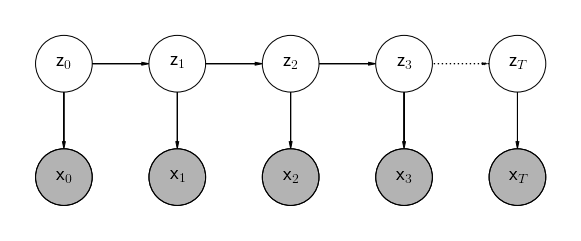

In [57]:
# code for plotting HMM graphical model using daft
rc("font", family="serif", size=20)
gm = daft.PGM([5, 2], origin=[0.5, 0.5], grid_unit=4, node_unit=2)
for t in range(4):
    gm.add_node(daft.Node('z_{0}'.format(t), r'$\mathsf{{z}}_{0}$'.format(t), t+1, 2))
    gm.add_node(daft.Node('x_{0}'.format(t), r'$\mathsf{{x}}_{0}$'.format(t), t+1, 1, observed=True))
    gm.add_edge('z_{0}'.format(t), 'x_{0}'.format(t))
    if t > 0:
        gm.add_edge('z_{0}'.format(t-1), 'z_{0}'.format(t))
gm.add_node(daft.Node('z_T', r'$\mathsf{z}_{T}$', t+2, 2))
gm.add_node(daft.Node('x_T', r'$\mathsf{x}_{T}$', t+2, 1, observed=True))
gm.add_edge('z_T'.format(t), 'x_T')
gm.add_edge('z_{0}'.format(t), 'z_T', plot_params={'linestyle' : 'dotted'})
gm.render()

The joint distribution factors are parametrised in terms of matrices $\mtx{A}$ and $\mtx{B}$ and a vector $\vct{\pi}$ as

\begin{align*}
\prob{\rvar{z}_t = i \gvn \rvar{z}_{t-1} = j} &= A_{ij} \qquad &\forall i \in \set{H}, ~j \in \set{H}
\\
\prob{\rvar{z}_0 = i} &= \pi_i \qquad &\forall i \in \set{H}
\\
\prob{\rvar{x}_t = i \gvn \rvar{z}_t = j} &= B_{ij} \qquad &\forall i \in \set{V}, ~j \in \set{H}
\end{align*}

To ensure the parameterd define valid normalised probability distributions it is required that

\begin{align*}
\sum_{i\in\set{H}} A_{ij} &= 1 \qquad \forall j \in \set{H} 
\qquad &
A_{ij} \geq 0 \qquad &\forall i \in \set{H}, ~ j \in \set{H}
\\
\sum_{i\in\set{V}} B_{ij} &= 1 \qquad \forall j \in \set{H} 
\qquad &
B_{ij} \geq 0 \qquad &\forall i \in \set{V}, ~ j \in \set{H}
\\
\sum_{i\in\set{V}} \pi_i &= 1
\qquad &
\pi_i \geq 0 \qquad &\forall i \in \set{H}
\end{align*}

It is also required that observations lie in correct state space i.e.

$$
x_t \in \set{V} \qquad \forall t \in \set{T} = \fset{0,1, \dots T}
$$

In [2]:
def check_params(A, B, p, x):
    assert all(A.sum(0) == 1.) and all(A.flat >= 0.), \
        'Columns must sum to one and elements be non-negative'
    assert all(B.sum(0) == 1.) and all(B.flat >= 0.), \
        'Columns must sum to one and elements be non-negative'
    assert p.sum(0) == 1. and all(p >= 0.), \
        'Elements must sum to one and be non-negative'
    assert A.shape[0] == A.shape[1] and A.shape[0] == B.shape[1], \
        'Inconsistent A and/or B shapes'
    assert min(x) >= 0 and max(x) <= B.shape[0], \
        'Observations must be integers in range 0-{0}'.format(B.shape[0])

## Inference (forward and backward algorithms)

Define 
$$\alpha^{(t)}_i = \prob{\rvar{z}_t=i, \rvct{x}_{0:t} = \vct{x}_{0:t}} \qquad \forall i \in \set{H}$$

then $\alpha^{(t+1)}_i$ can be calculated recursively from $\alpha^{(t)}_i$ using

\begin{align}
\alpha^{(t+1)}_i &= 
\prob{\rvar{z}_{t+1}=i, \rvct{x}_{0:t+1} = \vct{x}_{0:t+1}} \\
&=
\prob{\rvar{x}_{t+1} = x_{t+1} \gvn \rvar{z}_{t+1} = i} 
\prob{\rvar{z}_{t+1}=i, \rvct{x}_{0:t} = \vct{x}_{0:t}} \\
&=
\prob{\rvar{x}_{t+1} = x_{t+1} \gvn \rvar{z}_{t+1} = i} 
\sum_{j \in \set{H}} \lbr
  \prob{\rvar{z}_{t+1}=i \gvn \rvar{z}_{t}=j}
  \prob{\rvar{z}_{t}=j, \rvct{x}_{0:t} = \vct{x}_{0:t}}
\rbr \\
&=
B_{x_{t+1}i}
\sum_{j \in \set{H}} \lbr A_{ij} \alpha^{(t)}_j \rbr
\end{align}

or in matrix-vector notation
$$ \vct{\alpha}^{(t+1)} = \vct{B}_{x_{t+1}} \circ \mtx{A} \vct{\alpha}^{(t)} $$
with $\circ$ the elementwise product and $\vct{B}_{x_{t+1}}$ the column vector formed by taking the transpose of the $x_{t+1}^\text{th}$ row of $\mtx{B}$. The recursion is initialised using
$$ \vct{\alpha}^{(0)} = \vct{B}_{x_{0}} \circ \vct{\pi} $$

Similarly define
$$ \beta^{(t)}_i = \prob{\rvct{x}_{t+1:T} = \vct{x}_{t+1:T} \gvn \rvar{z}_t = z_t} \qquad \forall i \in \set{H} $$

then $\beta^{(t-1)}_i$ can be calculated recursively from $\beta^{(t)}_i$ using

\begin{align}
\beta^{(t-1)}_i  &= 
\prob{\rvct{x}_{t:T} = \vct{x}_{t:T} \gvn \rvar{z}_{t-1} = z_{t-1}} \\
&=
\sum_{j \in \set{H}} \lbr
  \prob{\rvct{x}_{t:T} = \vct{x}_{t:T}, \rvar{z}_t = j \gvn \rvar{z}_{t-1} = z_{t-1}}
\rbr \\
&=
\sum_{j \in \set{H}} \lbr
  \prob{\rvar{x}_{t} = x_{t} \gvn \rvar{z}_{t} = j} 
  \prob{\rvct{x}_{t+1:T} = \vct{x}_{t+1:T}, \rvar{z}_t = j \gvn \rvar{z}_{t-1} = z_{t-1}}
\rbr \\
&=
\sum_{j \in \set{H}} \lbr
  \prob{\rvar{x}_{t} = x_{t} \gvn \rvar{z}_{t} = j}
  \prob{\rvar{z}_t = j \gvn \rvar{z}_{t-1} = z_{t-1}}
  \prob{\rvct{x}_{t+1:T} = \vct{x}_{t+1:T} \gvn \rvar{z}_t = j}
\rbr \\
&=
\sum_{j \in \set{H}} \lbr  B_{x_t j} A_{ji} \beta^{(t)}_j \rbr
\end{align}

or in matrix-vector notation
$$ \vct{\beta}^{(t-1)} = \mtx{A}\tr \lpa \vct{B}_{x_{t+1}} \circ \vct{\beta}^{(t)} \rpa $$
The recursion is initialised using
$$ \vct{\beta}^{(T)} = \vct{1} $$

These two recursive update formulae for $\vct{\alpha}^{(t)}$ and $\vct{\beta}^{(t)}$ are called the forward and backward equations respectively (due to the direction of the recursion in each). Most conditional and marginal probabilities that might need to be inferred for a HMM can be expressed in terms of $\vct{\alpha}^{(t)}$ and $\vct{\beta}^{(t)}$ terms and the recursion formulae used to efficiently calculate them.

Functions for doing forward and backward passes given parameters and observations are

In [3]:
def forward(A, B, p, x):
    check_params(A, B, p, x)
    alphas = np.empty((len(x), A.shape[0])) * np.nan
    alphas[0] = B[x[0]] * p
    for t in range(1, len(x)):
        alphas[t] = B[x[t]] * A.dot(alphas[t-1])
    return alphas

def backward(A, B, p, x):
    check_params(A, B, p, x)
    betas = np.empty((len(x), A.shape[0])) * np.nan
    betas[-1] = np.ones(A.shape[0])
    for t in range(len(x)-2, -1, -1):
        betas[t] = A.T.dot(B[x[t]]*betas[t+1])
    return betas

## Problem set up

Consider problem on 3-element hidden state space $\set{H} = \fset{0,1,2}$, two element observed state space $\set{V} = \fset{0,1}$, with three observed time points $\set{T} = \fset{0,1,2}$. Model parameters (note 0 indexing for hidden/observed states and times) and observed states are as follows

$$
\mtx{A} = \lsb
\begin{array}{ccc}
0.5 & 0.0 & 0.0 \\
0.3 & 0.6 & 0.0 \\
0.2 & 0.4 & 1.0
\end{array}
\rsb
~~
\mtx{B} = \lsb
\begin{array}{ccc}
0.7 & 0.4 & 0.8 \\
0.3 & 0.6 & 0.2
\end{array}
\rsb
~~
\vct{\pi} = \lsb
\begin{array}{ccc}
0.9  \\
0.1 \\
0.0 
\end{array}
\rsb
~~
\vct{x}_{0:2} = \lsb
\begin{array}{ccc}
0  \\
1 \\
1 
\end{array}
\rsb
$$

In [4]:
A = np.array([[0.5, 0.3, 0.2], [0.0, 0.6, 0.4], [0.0, 0.0, 1.0]]).T
B = np.array([[0.7, 0.3], [0.4, 0.6], [0.8, 0.2]]).T
p = np.array([0.9, 0.1, 0.0])
x = [0,1,1]

Do forward pass to get $\vct{\alpha}^{(t)} ~\forall t \in \set{T}$

In [5]:
alphas = forward(A, B, p, x)
# code for pretty printing
Latex(r'\begin{align*}' +
    r'\\'.join([r'\vct{{\alpha}}^{{({0})}} &= \lsb {1} \rsb\tr'
                 .format(t, '~~'.join(['{0:.4f}'.format(a) for a in alpha])) 
                 for t, alpha in enumerate(alphas)]) + r'\end{align*}')

<IPython.core.display.Latex object>

Do backward pass to get $\vct{\beta}^{(t)} ~\forall t \in \set{T}$

In [6]:
betas = backward(A, B, p, x)
# code for pretty printing
Latex(r'\begin{align*}' +
    r'\\'.join([r'\vct{{\beta}}^{{({0})}} &= \lsb {1} \rsb\tr'
                 .format(t, '~~'.join(['{0:.4f}'.format(b) for b in beta])) 
                 for t, beta in enumerate(betas)]) + r'\end{align*}')

<IPython.core.display.Latex object>

### Question: Find $\prob{\rvct{x}_{0:2} = \vct{x}_{0:2}}$

$$
\prob{\rvct{x}_{0:2} = \vct{x}_{0:2}}
= \sum_{z\in\set{H}} \lbr \prob{\rvar{z}_2 = z, \rvct{x}_{0:2} = \vct{x}_{0:2}} \rbr
= \sum_{z\in\set{H}} \lbr \alpha^{(2)}_{z} \rbr
$$

In [7]:
P_x = alphas[2].sum()
# code for pretty printing
Latex(r'$\prob{{\rvct{{x}}_{{0:2}} = \vct{{x}}_{{0:2}}}} = {0:.4f}$'.format(P_x))

<IPython.core.display.Latex object>

### Question: Find $\prob{\rvar{z}_1 = z_1 \gvn \rvct{x}_{0:2} = \vct{x}_{0:2}}$

\begin{align*}
\prob{\rvar{z}_1 = z_1 \gvn \rvct{x}_{0:2} = \vct{x}_{0:2}}
&= 
\frac{\prob{\rvar{z}_1 = z_1, \rvct{x}_{0:2} = \vct{x}_{0:2}}}{\prob{\rvct{x}_{0:2} = \vct{x}_{0:2}}}
\\
&= 
\frac{
  \prob{\rvar{z}_1 = z_1, \rvct{x}_{0:1} = \vct{x}_{0:1}}
  \prob{\rvar{x}_2 = x_2 \gvn \rvar{z}_1 = z_1} 
}
{\prob{\rvct{x}_{0:2} = \vct{x}_{0:2}}}
\\
&= \frac{\alpha^{(1)}_{z_1}\beta^{(1)}_{z_1}}{\prob{\rvct{x}_{0:2} = \vct{x}_{0:2}}}
\end{align*}

In [58]:
P_z1_gvn_x = alphas[1]*betas[1] / P_x
# code for pretty printing
Latex(
    r'$$ \prob{\rvar{z}_1 = z_1 \gvn \rvct{x}_{0:2} = \vct{x}_{0:2}} =' +
    r'\begin{cases}' +
    r'\\'.join([r'{0:.4f} \qquad : ~ z_1 = {1}'
        .format(p, z1) for z1, p in enumerate(P_z1_gvn_x)]) +
    r'\end{cases}$$')

<IPython.core.display.Latex object>